
# Modelo de Machine Learning - Classificação
Este script tem como objetivo desenvolver um algoritmo para classificar se determinado cliente irá contratar ou não o novo serivço oferecido:
- Inicialmente será desenvolvido o algoritmo de árvore de decisão


1. [Seleção dos Dados](#selecao)
2. [Modelo de ML](#modelo)
    
    2.1. [Base de Treino e Teste](#split_base),
    
    2.2. [Balanceando a base de dados](#imblearn)
    
    2.3. [Árvore de Decisão](#arvore)
    
    2.3.1.[Resultado](#resultados)
    
    
3. [Conclusão](#conclusao)


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
#from sklearn.naive_bayes import GaussianNB
#from sklearn.ensemble import RandomForestClassifier

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
import warnings

from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

<font color='red'> **FUNÇÕES** </font>

Funções desenvolvidas para automatizar a teste, execução e validação dos modelos

In [2]:
## função para plotar matriz de confusão
def plot_cm(cm, labels):
    """
    Função para criar e plotar a matriz de confusão
    """
    # calcula porcentagens 
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)
    
    print('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()) )

    # Show confusion matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    

## função para executar modelos de ML
def run_ml(modelos, X_train,X_test,y_train,y_test):
    """
    Função para executar algoritmos 
    """
    lista_metrics = list()
    
    for m in modelos:
        
        print("\n==>",m.__class__.__name__)
        
        clf = Pipeline([('clf', m )])

        clf       = clf.fit(np.asarray(X_train), y_train)
        
        predicted = clf.predict(np.asarray(X_test))
        print(" Accuracy  = %f \n" % accuracy_score(y_test, predicted))
        
        labels = list(np.unique(y_train)) #[0,1]
        cm     = confusion_matrix(y_test, predicted,labels=labels)
        
        if plotCm:
            plot_cm(cm,labels)

        if hasattr(clf, 'predict_proba') and plotAuc:
            plot_auc_curve(clf, X_test, y_test)
        
        metric = get_metrics(predicted, y_test)
        metric['modelo'] = m.__class__.__name__
        
        etc_eval     = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 10)
        metric["CV"] = etc_eval.mean()
        
        print(metric)
        
        lista_metrics.append(metric)
        
    print("\n","="*30,'FEATURE IMPORTANCES','='*40)

    ##  CHECKING FEATURES IMPORTANCES 
    if feat_import:
        for m in modelos:
            if hasattr(m, 'feature_importances_'):
                print("\n==>",m.__class__.__name__)
                cols = X_train.columns
                m.fit(np.asarray(X_train),y_train)

                x_labels = X_train.columns[:]
                prob     = list()        
                cols     = list()        
                features = m.feature_importances_
                mean_features = np.mean(features)
                for i,l in zip(x_labels,features):
                    l = l* 100
                    if l > int( mean_features*100 ):
                        cols.append((i,str(round(l,2))+"%" ))
                        
                print("  Cols: ", cols)
                cols = [c[0] for c in cols]
                
                clf  = m.fit(np.asarray(X_train.loc[:,cols]), y_train)
                predicted = clf.predict(np.asarray(X_test.loc[:,cols]))

                print("  Accuracy  = %f \n" % accuracy_score(y_test, predicted))
                labels = list(np.unique(y_train)) #[0,1]
                cm     = confusion_matrix(y_test, predicted,labels=labels)    

                if plotCm:
                    plot_cm(cm,labels)

                if hasattr(clf, 'predict_proba') and plotAuc:
                    plot_auc_curve(clf, X_test.loc[:,cols], y_test)
                
                metric = get_metrics(predicted, y_test)
                metric['modelo'] = m.__class__.__name__ + ' feature_importance'
                metric['features'] = cols

                etc_eval     = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = 10)
                metric["CV"] = etc_eval.mean()

                print(metric)

                lista_metrics.append(metric)
                    
    return lista_metrics

def get_metrics(predicted, y_test):
    """
    Função para calcular as métricas do modelo ML
    """
    
    metric = dict()

    metric["ACC"]       = accuracy_score(y_pred=predicted,y_true=y_test)
    metric["PRECISION"] = np.mean(metrics.precision_score(y_pred=predicted,y_true=y_test,average=None))
    metric["RECALL"]    = np.mean(metrics.recall_score(y_pred=predicted,y_true=y_test,average=None))
    metric["FSCORE"]    = np.mean(metrics.f1_score(y_pred=predicted,y_true=y_test,average=None,pos_label='H'))
        
    return metric

## função para plotar AUC Curve 
def plot_auc_curve(clf, X_test, y_test):
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    fpr, tpr, _  = metrics.roc_curve(y_test,  y_pred_proba)
    auc          = metrics.roc_auc_score(y_test, y_pred_proba)

    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

## <a id = "selecao"> 1. Importação e Seleção dos Dados </a>


In [3]:
dados = pd.read_csv('data/dados_limpos.csv')

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31140 entries, 0 to 40689
Data columns (total 27 columns):
age              31140 non-null int64
job              31140 non-null object
marital          31140 non-null object
education        31140 non-null object
default          31140 non-null object
housing          31140 non-null object
loan             31140 non-null object
contact          31140 non-null object
day              31140 non-null int64
month            31140 non-null object
duration         31140 non-null int64
campaign         31140 non-null int64
pdays            31140 non-null int64
poutcome         31140 non-null object
y                31140 non-null object
month_new        31140 non-null int64
job_new          31140 non-null int64
marital_new      31140 non-null int64
education_new    31140 non-null int64
default_new      31140 non-null int64
housing_new      31140 non-null int64
loan_new         31140 non-null int64
contact_new      31140 non-null int64
poutcom

In [5]:
features = ['age', 'day', 'campaign', 'pdays',
            'month_new', 'job_new', 'marital_new', 'education_new',
            'default_new', 'housing_new', 'loan_new', 'contact_new', 'poutcome_new',
            'balance_new', 'duration_new','y_new']

In [6]:
dados_selec = dados[features]
dados_selec.columns

Index(['age', 'day', 'campaign', 'pdays', 'month_new', 'job_new',
       'marital_new', 'education_new', 'default_new', 'housing_new',
       'loan_new', 'contact_new', 'poutcome_new', 'balance_new',
       'duration_new', 'y_new'],
      dtype='object')

## <a id = "modelo"> 2. Modelo ML </a>
- Pra validar o modelo serão utilizadas as seguintes métricas:
    - matriz de confusão
    - acurácia
    - precision
    - recall
    - fscore
    - cross-validation
    - curva AUC

### <a id = "split_base"> 2.1 Base de Treino e Teste </a>

**Dividindo dados em base de treino e teste** - 80% treino e 20% teste

In [7]:
x = dados_selec.drop(columns=['y_new'])
y = dados_selec.y_new

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size = .2, random_state = 42)

### <a id = "imblearn"> 2.2 Balancemaento da base de treino  </a>
Como foi identificado na análise exploratória, os dados estão bem desbalanceado, para resolver este problema pode-se utilizar duas técnicas:
- **undersampling**: diminuir a classe majoritária até igualar com a classe minoritária
- **oversampling**: "aumentar" a classe minoritária até igualar a classe majoritária. Essa técnica é a mais recomendada para evitar que se perca informações da base de dados.

In [8]:
smote = SMOTE()
x_treino_balanc, y_treino_balanc = smote.fit_sample(x_treino,y_treino)

In [9]:
print(y_treino.value_counts(),'\n',y_treino_balanc.value_counts())

0    22792
1     2120
Name: y_new, dtype: int64 
 1    22792
0    22792
Name: y_new, dtype: int64


In [10]:
## VARIAVEIS GLOBAIS QUE SÃO UTILIZADAS NAS FUNÇÕES
global plotAu, plotCm, feat_import
feat_import = True ## indica se vai utilizar feature importance
plotAuc = True ## indica se vai plotar a curva AUCA
plotCm  = True ## indica se vai plotar a matriz de confusão


### <a id = "arvore"> 2.3 Árvore de decisão </a>

O primeiro modelo a ser elaborador será árvore de decisão, este tipo de algoritmo se comporta bem para classificação binária, além de,  uma das vantagens deste modelo é conseguir generalizar bem dados discretos, então, não será necessário realizar transformações mais avançadas na base de dados.

- Foi alterado o valor do parâmetro *max_depth* para evitar overfitting
- Serã treinado o modelo de árvore de decisão com todas as colunas e com as colunas mais importantes(feature_importance)


==> DecisionTreeClassifier
 Accuracy  = 0.876204 

Confusion Matrix Stats
0/0: 89.62% (5157/5754)
0/1: 10.38% (597/5754)
1/0: 36.71% (174/474)
1/1: 63.29% (300/474)


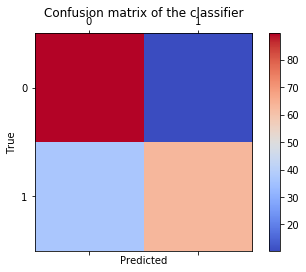

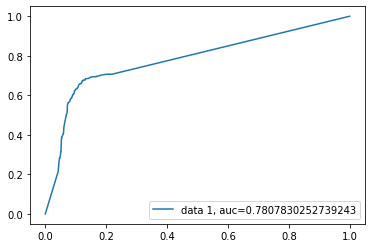

{'ACC': 0.876204238921002, 'PRECISION': 0.6509044404251274, 'RECALL': 0.764578741040905, 'FSCORE': 0.684041655439517, 'modelo': 'DecisionTreeClassifier', 'CV': 0.917670023015486}

 ============================== FEATURE IMPORTANCES ========================================

==> DecisionTreeClassifier
  Cols:  [('day', '6.1%'), ('month_new', '10.61%'), ('housing_new', '27.36%'), ('contact_new', '7.8%'), ('duration_new', '22.87%')]
  Accuracy  = 0.846660 

Confusion Matrix Stats
0/0: 86.13% (4956/5754)
0/1: 13.87% (798/5754)
1/0: 33.12% (157/474)
1/1: 66.88% (317/474)


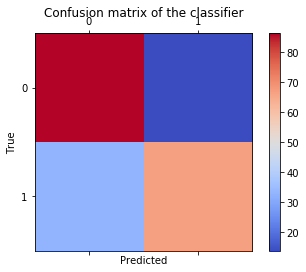

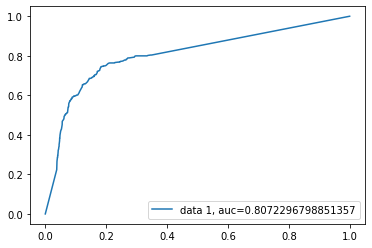

{'ACC': 0.846660244059088, 'PRECISION': 0.6267994446583447, 'RECALL': 0.7650451199605778, 'FSCORE': 0.6555561687762843, 'modelo': 'DecisionTreeClassifier feature_importance', 'features': ['day', 'month_new', 'housing_new', 'contact_new', 'duration_new'], 'CV': 0.917670023015486}


In [11]:
modelo_dt = DecisionTreeClassifier(random_state=42, max_depth=15)
resultados = run_ml([modelo_dt], x_treino_balanc,x_teste,y_treino_balanc,y_teste)

In [12]:
pd.DataFrame(resultados)[['modelo','features','ACC', 'PRECISION', 'RECALL', 'FSCORE',  'CV']]

,modelo,features,ACC,PRECISION,RECALL,FSCORE,CV
0,DecisionTreeClassifier,NaN,0.876204,0.650904,0.764579,0.684042,0.91767
1,DecisionTreeClassifier feature_importance,"[day, month_new, housing_new, contact_new, dur...",0.846660,0.626799,0.765045,0.655556,0.91767


In [27]:
modelo_dt = DecisionTreeClassifier(random_state=42, max_depth=15)
modelo_dt.fit(x_treino_balanc[['day','month_new','housing_new','contact_new','duration_new']], y_treino_balanc)

previsao_teste  = modelo_dt.predict(x_teste[['day','month_new','housing_new','contact_new','duration_new']])

x_teste['y'] = previsao_teste
x_teste.to_csv('data/dados_previstos.csv',index=False)

### <a id = "resultados"> 2.3.1 Resultados </a>
- O modelo com todas as colunas teve um resultado um pouco melhor nas métricas: `acurárica(acc), precision, recall, fscore`
- A métrica de `cross-validation` é igual para ambos os modelos.
- Mas, pela matriz de confusão podemos identificar que o modelo com `features_importance` teve um resultado melhor para os *verdadeiro positivo* (que é a classe alvo do modelo)
- Por fim, pela `curva AUC` é possível observar que o modelo com `features_importance` também teve um melhor resultado.

## <a id = "conclusao"> 3. Conclusão </a>
- a eliminação dos registros outlier pode ter interferido no resultado do modelo. Poderia tentar fazer a correção destes registros ao invés de excluir e testar novamente o modelo
- o desbalanceamento da base pode está inteferindo diretamente no resultado
- o modelo com `features_importance`confirma análise feita anteriormente, que os campos `month, duration` são importantes, além das colunas  `housing` e `contact`, para definir se o cliente vai adquirir ou não o serviço.
- em relação a coluna `contact` deve-se fazer uma análise mais aprofundada, porque é um atributo muito deslabanceado, então, não necessariamente é tão relevante para o modelo.
- Poderia treinar outros modelos como *naive bayes e random forest* outros algoritmos que generalizam bem para classificação binária. 
- Por fim, poderia treinar este modelo e outros com "tuning" dos hiperparâmetros.